# Sidekick - Mixture of Least Squares
We train a mixture of least squares, experimenting with different number of components.

In [14]:
%matplotlib inline
from __future__ import print_function
import os
import sys
sys.path.insert(0, os.path.abspath('../utils/')) # Add sibling to Python path
sys.path.insert(0, os.path.abspath('../src/')) # Add sibling to Python path
sys.stdout.flush() # Print output on the fly in Notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (18,8)
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['legend.fontsize'] = 16
from IPython.display import display
import numpy as np
import pickle as cp
import matplotlib.pyplot as plt
from math import floor
from dataset import Sidekick
from model import LeastSquaresMixture
from collections import Counter
from progressbar import ProgressBar

DATA_DIR = "../data/sidekick"

def subsample(t0, t1, n_samples):
    t = t1 - t0
    if n_samples >= t:
        return range(t0, t1)
    samples = range(t0, t1, int(np.ceil(t / float(n_samples))))
    return samples

## Load and split data

In [15]:
sk = Sidekick()
sk.load(light=True)
projects_train, projects_test = sk.split()

Loading light data set (1000 data points)...
Data loaded.


## Data processing

In [16]:
N = 1000
N_train = int(floor(0.8*N))
seed = 2
t0 = 1
t1 = 500
n_samples = 100
T = 999

samples = subsample(t0, t1, n_samples)
t = len(samples)

#N_projects = sk.choose_n_projects(n=N, seed=seed)
#projects_train = N_projects[:N_train]
#projects_test = N_projects[N_train:]

#with open("../data/sidekick/light.pkl", 'wb') as f:
#    cp.dump(N_projects, f)

X_train = np.ndarray(shape=(len(projects_train), t), buffer=np.array([p.money[samples] for p in projects_train]), dtype=float) 
y_train = np.expand_dims(np.array([p.money[T] for p in projects_train]), axis=1)
X_test = np.ndarray(shape=(len(projects_test), t), buffer=np.array([p.money[samples] for p in projects_test]), dtype=float) 
y_test = np.expand_dims(np.array([p.money[T] for p in projects_test]), axis=1)

# Required to contain the prediction in a reasonable range
# The problem arises when evaluating the likelihood in the expression for gamma_nk
X_max = np.max(X_train, axis=0)
X_train = X_train / X_max[np.newaxis, :]
# Apply same preprocessing to testing set
X_test = X_test / X_max[np.newaxis, :]  

print("Training on %s projects" % len(X_train))
print("Testing on %s projects" % len(X_test))
print("Number of features: %s" % n_samples)

Training on 800 projects
Testing on 200 projects
Number of features: 100


## Train Mixture of Least Squares

In [13]:
K = 5
beta = 1
epsilon = 1e-6
lam = 1e-6
iterations = 1000
random_restarts = 20

mls = LeastSquaresMixture(X_train, y_train, 
                          K=K, beta=beta, lam=lam, 
                          iterations=iterations, epsilon=epsilon, random_restarts=random_restarts)
mls.train()
print("Model trained!")

Random restarts (20/20): [####################] 100% Elapsed time: 0:02:30
Model trained!


## Display model

In [9]:
print(mls)

Model: LeastSquaresMixture (5 components)
Likelihood: -50.1495934604906
Beta: 52.448182377211225
Lambda: 0.01
Pi: [ 0.10002485  0.24596787  0.17418854  0.25829067  0.22152806]
Weights: (norm: [20.725831366611295, 10.475542640297597, 5.7169088767106757, 9.2497470750125679, 6.8729804510566126])



## Evaluation

In [11]:
rmse, accuracy, chosen = mls.evaluate(X_test, y_test, verbose=True)

Evaluating model LeastSquaresMixture (5 components)...
Data point (200/200): [####################] 100% Elapsed time: 0:00:03
Accuracy: 0.76
RMSE    : 16.0643704465
Chosen  : Counter({4: 77, 0: 41, 1: 36, 2: 23, 3: 23})


In [17]:
K = 2
epsilon = 1e-6
iterations = 1000
random_restarts = 20
betas = np.logspace(-6, 0, 10)
lambdas = np.logspace(-6, 5, 10)

rmse_all = []
accuracy_all = []

count = 0
bar = ProgressBar(len(betas) * len(lambdas))
bar.start()
for i, l in enumerate(lambdas):
    rmse_i = []
    accuracy_i = []
    for j, b in enumerate(betas):
        mls = LeastSquaresMixture(X_train, y_train, K=K, beta=b, lam=l,
                          iterations=iterations, epsilon=epsilon, random_restarts=random_restarts)
        mls.train(silent=True)
        rmse, accuracy, _ = mls.evaluate(X_test, y_test)
        rmse_i.append(rmse)
        accuracy_i.append(accuracy)
        bar.update(count)
        count += 1
    rmse_all.append(rmse_i)
    accuracy_all.append(accuracy_i)
    
with open('accuracy_all.pkl', 'wb') as f:
    cp.dump(accuracy_all, f)
with open('rmse_all.pkl', 'wb') as f:
    cp.dump(rmse_all, f)
    

Progress: [################### ] 96%Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
Progress: [################### ] 97%Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
Progress: [####################] 98%Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
Hitting maximum iteration (1000)
H

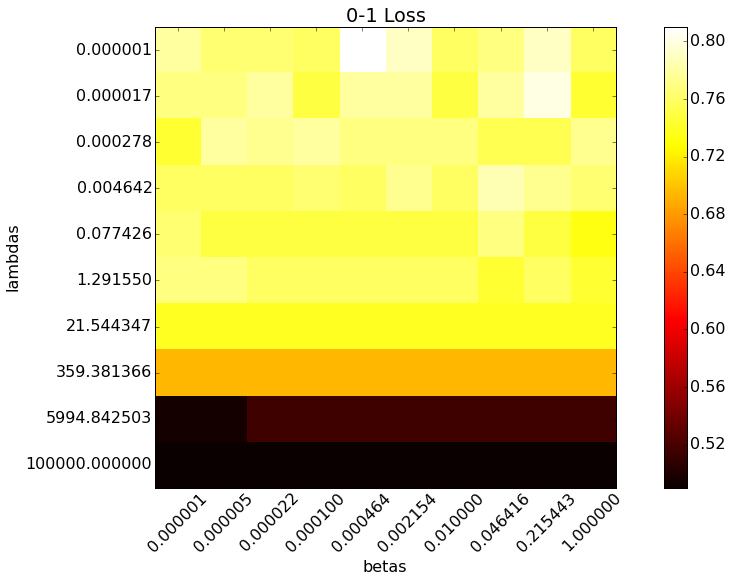

In [93]:
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(accuracy_all, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('betas')
plt.ylabel('lambdas')
plt.colorbar()
plt.xticks(np.arange(len(betas)), ["%0.6f" % b for b in betas], rotation=45)
plt.yticks(np.arange(len(lambdas)), ["%0.6f" % l for l in lambdas])
plt.title('0-1 Loss')
plt.show()

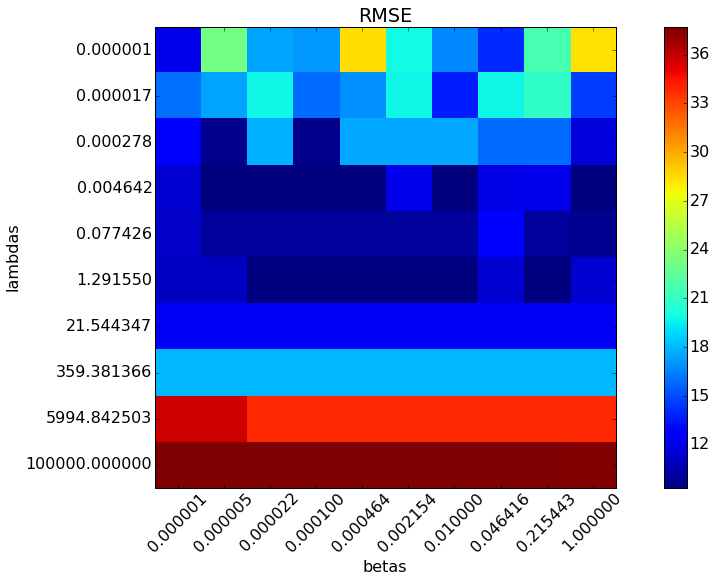

In [75]:
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(rmse_all, interpolation='nearest')
plt.xticks(np.arange(len(betas)), ["%0.6f" % b for b in betas], rotation=45)
plt.yticks(np.arange(len(lambdas)), ["%0.6f" % l for l in lambdas])
plt.colorbar()
plt.title('RMSE')
plt.xlabel('betas')
plt.ylabel('lambdas')
plt.show()

In [81]:
indices = np.unravel_index(np.argmax(accuracy_all), np.shape(accuracy_all))
optimal_lambda = lambdas[indices[0]]
optimal_beta = betas[indices[1]]
print("Optimal lambda: %s" % optimal_lambda)
print("Optimal beta  : %s" % optimal_beta)

Optimal lambda: 1e-06
Optimal beta  : 0.000464158883361


In [83]:
indices = np.unravel_index(np.argmin(rmse_all), np.shape(rmse_all))
optimal_lambda = lambdas[indices[0]]
optimal_beta = betas[indices[1]]
print("Optimal lambda: %s" % optimal_lambda)
print("Optimal beta  : %s" % optimal_beta)

Optimal lambda: 1.29154966501
Optimal beta  : 0.00215443469003
